In [1]:
import datasets
import os
import json

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
data_path = '/home/ubuntu/nemo_customiser_k8_utils/data'
dataset = datasets.load_dataset(data_path)

In [8]:
# Assuming 'label' is the column you want to stratify by
stratify_column_name = "label"

# Cast the column to ClassLabel
dataset = dataset.class_encode_column(stratify_column_name)

In [9]:
DATASET_PROMPT_FORMAT = """Given the following headline:
### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Choose from the following list:

-analyst rating
-price targets
-earnings
-labour related
-mergers and acquisitions
-dividends
-regulatory
-stock price movement
-credit ratings
-products-services
-product approval
-guidance
-other

Provide only the event type putting it inside double square brackets and in a new line like:
[[label]]

### START EVENT OUTPUT ###

"""

In [10]:
train_ratio = 0.8
val_ratio = 0.15
seed = 42
test_ratio = 1 - train_ratio - val_ratio
save_splits = {}
dataset = dataset.get('train')
# Get the class labels
class_labels = dataset.features['label']
split_dataset = dataset.train_test_split(test_size=val_ratio + test_ratio, seed=seed, stratify_by_column='label')
split_dataset2 = split_dataset['test'].train_test_split(
    test_size=test_ratio / (val_ratio + test_ratio), seed=seed,stratify_by_column='label')
save_splits['training'] = split_dataset['train']
save_splits['validation'] = split_dataset2['train']
save_splits['test'] = split_dataset2['test']

print("len training: ", len(save_splits['training']))
print("len validation: ", len(save_splits['validation']))
print("len test: ", len(save_splits['test']))

len training:  122808
len validation:  23027
len test:  7676


In [11]:
dataset_root = "data"
os.makedirs(dataset_root, exist_ok=True)

for split_name, dataset in save_splits.items():
    output_file = os.path.join(dataset_root, f"{split_name}.jsonl")
    print(f"Processing {split_name} to {output_file}")
    with open(output_file,"w", encoding="utf-8") as f:
        for example in dataset:
            if DATASET_PROMPT_FORMAT != "":
                _input = DATASET_PROMPT_FORMAT.format(headline=example["headline"])
                _output = class_labels.int2str(example["label"])
            f.write(json.dumps({"prompt": _input, "completion": _output}) + "\n")

    print(f"{split_name} split saved to {output_file}")

Processing training to data/training.jsonl
training split saved to data/training.jsonl
Processing validation to data/validation.jsonl
validation split saved to data/validation.jsonl
Processing test to data/test.jsonl
test split saved to data/test.jsonl


<Figure size 3000x1500 with 0 Axes>

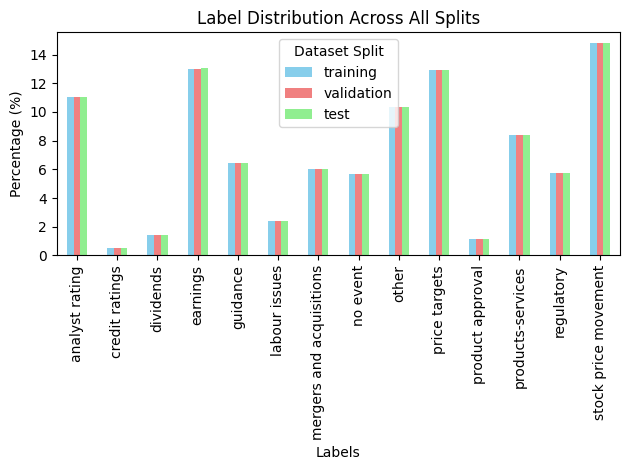

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for all splits
distribution_data = {}
for split, data in save_splits.items():
    df = data.to_pandas()
    df['label'] = df['label'].apply(lambda x: class_labels.int2str(x))
    df_distribution = (df.groupby('label').size()/df.shape[0])*100
    distribution_data[split] = df_distribution

# Convert to DataFrame for easier plotting
combined_df = pd.DataFrame(distribution_data).fillna(0)

# Create the plot
plt.figure(figsize=(30, 15))
combined_df.plot(kind='bar', 
                 title='Label Distribution Across All Splits',
                 xlabel='Labels', 
                 ylabel='Percentage (%)',
                 rot=90,
                 color=['skyblue', 'lightcoral', 'lightgreen'])

plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()